This notebook is used to create the index arrays for our edges after spatial reduction to fit our model in stan in R.

In [1]:
import xarray as xr
import numpy as np

In [2]:
tp_quantile = 0.0013141632
ws10_quantile = 11.48831558227539

Let us analyse hurricane Michael for now.

In [3]:
speeds = xr.open_dataset("../data_grib/ANDEREW_1992_08.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [165, 166]}})
rainfall = xr.open_dataset("../data_grib/ANDEREW_1992_08.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [228]}})
extra = xr.open_dataset("../data_grib/ANDEREW_1992_08.grib", engine='cfgrib', backend_kwargs={'filter_by_keys': {'paramId': [134, 34]}})

speeds = speeds.to_dataframe()
rainfall = rainfall.to_dataframe()
extra = extra.to_dataframe()

u_speed = speeds.u10
v_speed = speeds.v10
ws10 = np.sqrt(u_speed**2 + v_speed**2)

speeds["ws10"] = ws10

Ignoring index file '../data_grib/ANDEREW_1992_08.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ANDEREW_1992_08.grib.5b7b6.idx' incompatible with GRIB file
Ignoring index file '../data_grib/ANDEREW_1992_08.grib.5b7b6.idx' incompatible with GRIB file


In [4]:
y1 = speeds.ws10.loc['1992-08-24 12:00:00']

test = rainfall.droplevel(level=[0,1])
vals = test.set_index([test.valid_time, test.index])
vals = vals.rename_axis(index={"valid_time":"time"})

y2 = vals.tp.loc['1992-08-24 12:00:00']

y3 = extra.sp.loc['1992-08-24 12:00:00']

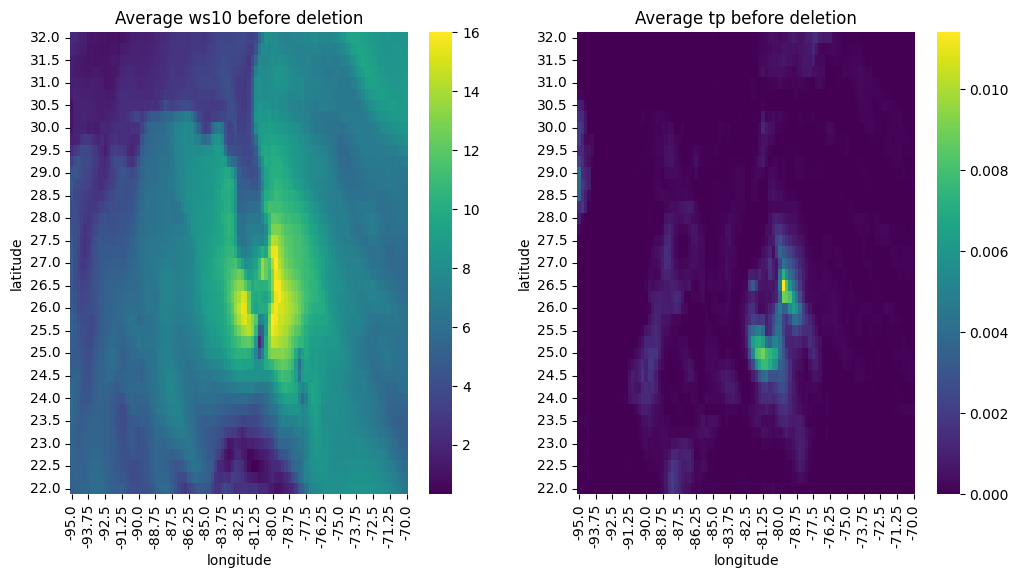

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.heatmap(y1.unstack(), cmap='viridis')
plt.title('Average ws10 before deletion')

plt.subplot(122)
sns.heatmap(y2.unstack(), cmap='viridis')
plt.gca().invert_yaxis()
plt.title('Average tp before deletion')
plt.show()

In [14]:
mask_ws10 = y1 > ws10_quantile
mask_tp = y2 > tp_quantile

combined_mask = mask_ws10 | mask_tp

In [15]:
combined_mask.sum()

np.int64(259)

In [16]:
# Ensure combined_mask has a MultiIndex (lon, lat)
temp = combined_mask.unstack()
lat = temp.index.values
lon = temp.columns.values

# Loop over lat and lon and apply your conditions
for i in range(len(lat)):
    for j in range(len(lon)):

        # Set to False if outside the specified bounds
        if lat[i] <= 23 or lat[i] >= 29 or lon[j] <= -85 or lon[j] >= -75:

            combined_mask.loc[(lat[i], lon[j])] = False

        # Set to True if within the specified bounds (25 <= lon <= 27, 79 <= lat <= 83)
        if 25 <= lat[i] <= 27.5 and -82.5 <= lon[j] <= -79:

            combined_mask.loc[(lat[i], lon[j])] = True


In [17]:
combined_mask.sum()

np.int64(270)

In [18]:
y1_filtered = y1.where(combined_mask)

temp = y1_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

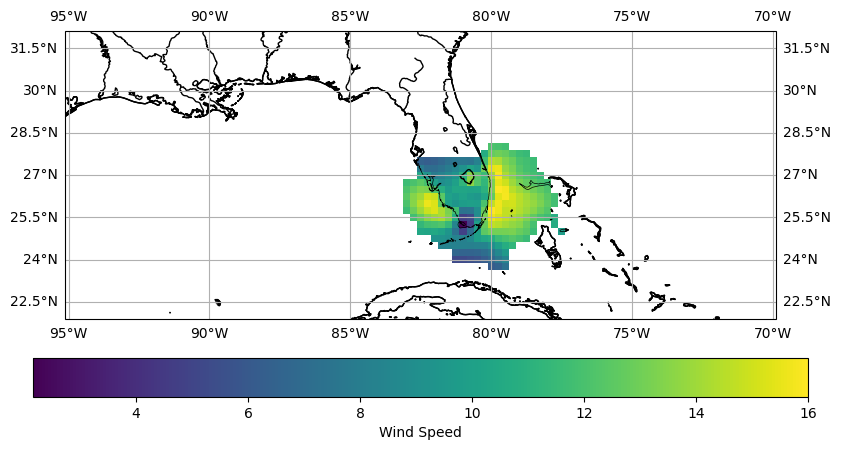

In [20]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Wind Speed')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

In [21]:
y1_values = []

k = 0

for i in range(101):

    for j in range(40):

        if not np.isnan(data_grid[j,i]):

            y1_values.append(data_grid[j,i])

In [22]:
np.savetxt("pre_icar_data/y_ws10.csv", y1_values, delimiter=",", fmt="%.6f")

In [23]:
y2_filtered = y2.where(combined_mask)

temp = y2_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

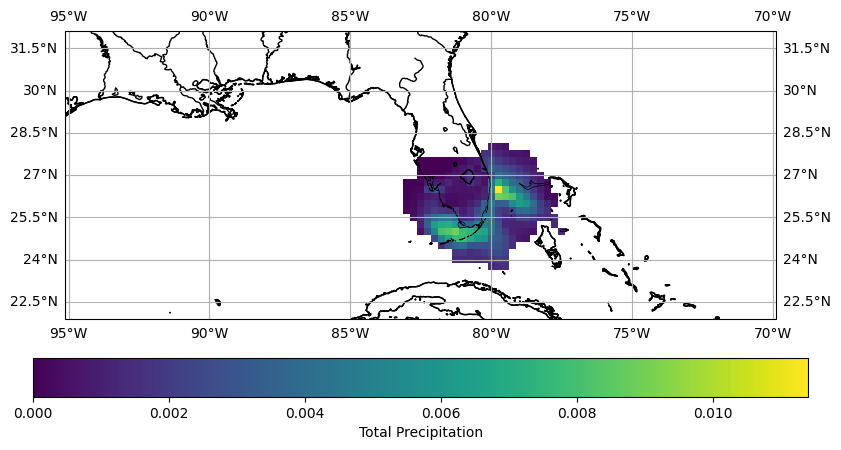

In [24]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Total Precipitation')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

In [25]:
y2_values = []

k = 0

for i in range(101):

    for j in range(40):

        if not np.isnan(data_grid[j,i]):

            y2_values.append(data_grid[j,i])

In [26]:
np.savetxt("pre_icar_data/y_tp.csv", y2_values, delimiter=",", fmt="%.6f")

In [27]:
y3_filtered = y3.where(combined_mask)

temp = y3_filtered.unstack()
lat = temp.index.values
lon = temp.columns.values
data_grid = temp.values

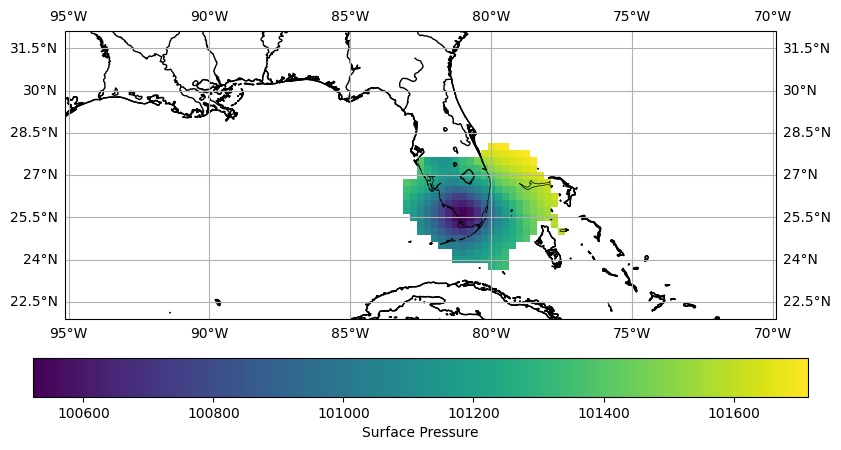

In [28]:
fig, ax = plt.subplots(figsize=(10, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

#ax.set_extent([-70, -95, 32, 22])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='black')

heatmap = ax.pcolormesh(lon, lat, data_grid, cmap='viridis', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.1)
cbar.set_label('Surface Pressure')

# Add gridlines
ax.gridlines(draw_labels=True)

# Show the plot
plt.show()

ax.set_title(f'Correlation between ws10 and tp', fontsize=16)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12);

In [29]:
y3_values = []

k = 0

for i in range(101):

    for j in range(40):

        if not np.isnan(data_grid[j,i]):

            y3_values.append(data_grid[j,i])

In [30]:
np.savetxt("pre_icar_data/y_sp.csv", y3_values, delimiter=",", fmt="%.6f")

In [31]:
mask = combined_mask.unstack()
lat = mask.index.values
lon = mask.columns.values

In [32]:
# Initialise our adjacency matrix which would be NxN

N = len(lat)*len(lon)
adj = np.zeros((N, N))

adj

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
# Define a function to check if node i is kept after spatial reduction

lat_temp = lat[::-1]

def retained(mask, i):

    lat_i = i % len(lat)
    lon_i = i // len(lat)

    return mask.loc[lat[lat_i], lon[lon_i]]

In [34]:
# Start filling out the matrix where Aij = 1 if i and j are neighbours
# Start from top left of the map i.e lon = 95, lat = 32 and go down

i,j = 0,0

# Fill in the upper triangular of the matrix

for i in range(0,N):

    #Check if node i is retained

    if retained(mask, i):

        for j in range(i+1,N):
            
            # Check if node j is retained
                
            if retained(mask, j):

                # Check if nodes i and j are neigbours

                lat_i, lon_i = i % len(lat), i // len(lat)
                lat_j, lon_j = j % len(lat), j // len(lat)

                if lat_i == lat_j and abs(lon_j - lon_i) == 1:

                    adj[i,j] = 1

                elif lon_i == lon_j and abs(lat_i - lat_j) == 1:

                    adj[i,j] = 1


In [35]:
# Filling in the lower triangular
adj_complete = adj + adj.T

Now I want to convert the Adjacency Matrix into two lists defining all our edges.

In [36]:
N_edges = int(adj.sum())
N_edges

496

In [37]:
node1 = np.zeros(N_edges)
node2 = np.zeros(N_edges)

In [38]:
# This is the number of neighbours each node has, we are using the upper triangular to avoid a double count
# i.e if nodes 3 and 9 are neigbours, we will only consider 3 --> 9 and not 9 --> 3.
neighbours = adj.sum(axis=1)
neighbours

array([0., 0., 0., ..., 0., 0., 0.])

In [39]:
i = 0

for k in range(len(neighbours)):

    count = int(neighbours[k])
    
    if count != 0:

        locations = np.nonzero(adj[k])

        for m in range(count):

            # node1 stores the start index of the edges
            node1[i] = k+1

            # node2 stores the end index of the edges
            node2[i] = locations[0][m] + 1

            i += 1 

These are indexes on the full dataset. I want to reduce it to just extreme locations.

In [42]:
#mask = mask.iloc[::-1]
df_list = mask.to_numpy().flatten(order='F').tolist()

In [43]:
extreme_indices = [i for i, val in enumerate(df_list) if val]

extreme_to_new_idx = {extreme_indices[i] + 1: i + 1 for i in range(len(extreme_indices))}

In [45]:
node1_reduced = []
node2_reduced = []

for i in range(len(node1)):

    node1_reduced.append(extreme_to_new_idx[int(node1[i])])
    node2_reduced.append(extreme_to_new_idx[int(node2[i])])

Repeat the same but for the correlation matrix now. The neighbours of the correlation between node i and j are the correlations between i and its neigbours and correlations between j and its neighbours.

In [46]:
reversed_map = {v: k for k, v in extreme_to_new_idx.items()}

In [47]:
def find_indices(value, arr):
    
    return [i for i,x in enumerate(arr) if x == value]

find_indices(3, node1_reduced)

[4, 5]

In [48]:
rho_node1 = []
rho_node2 = []

N = sum(df_list)

neighbours_full = adj_complete.sum(axis=1)

for k in range(len(node1_reduced)):

    i = node1_reduced[k]
    j = node2_reduced[k]

    count = int(neighbours_full[reversed_map[i]-1]) + int(neighbours_full[reversed_map[j]-1]) - 2 #Don't want to count the i,j edge

    if count > 0:

        for m in range(count):

            rho_node1.append(k+1)

    for a in find_indices(i, node1_reduced):

        if node2_reduced[a] != j:

            rho_node2.append(a+1)

    for a in find_indices(i, node2_reduced):

        if node1_reduced[a] != j:

            rho_node2.append(a+1)

    for a in find_indices(j, node1_reduced):

        if node2_reduced[a] != i:

            rho_node2.append(a+1)

    for a in find_indices(j, node2_reduced):

        if node1_reduced[a] != i:

            rho_node2.append(a+1)

In [49]:
len(rho_node1) == len(rho_node2)

True

In [50]:
len(rho_node1) == len(rho_node2)

True

Now I want to export these lists so I can use them in R

In [52]:
np.savetxt("pre_icar_data/node1.csv", node1_reduced, delimiter=",", fmt="%d")

np.savetxt("pre_icar_data/node2.csv", node2_reduced, delimiter=",", fmt="%d")

In [53]:
np.savetxt("pre_icar_data/rho_node1.csv", rho_node1, delimiter=",", fmt="%d")

np.savetxt("pre_icar_data/rho_node2.csv", rho_node2, delimiter=",", fmt="%d")